In [34]:
using JuMP, Ipopt, Plots
using Images, QuartzImageIO, ImageView

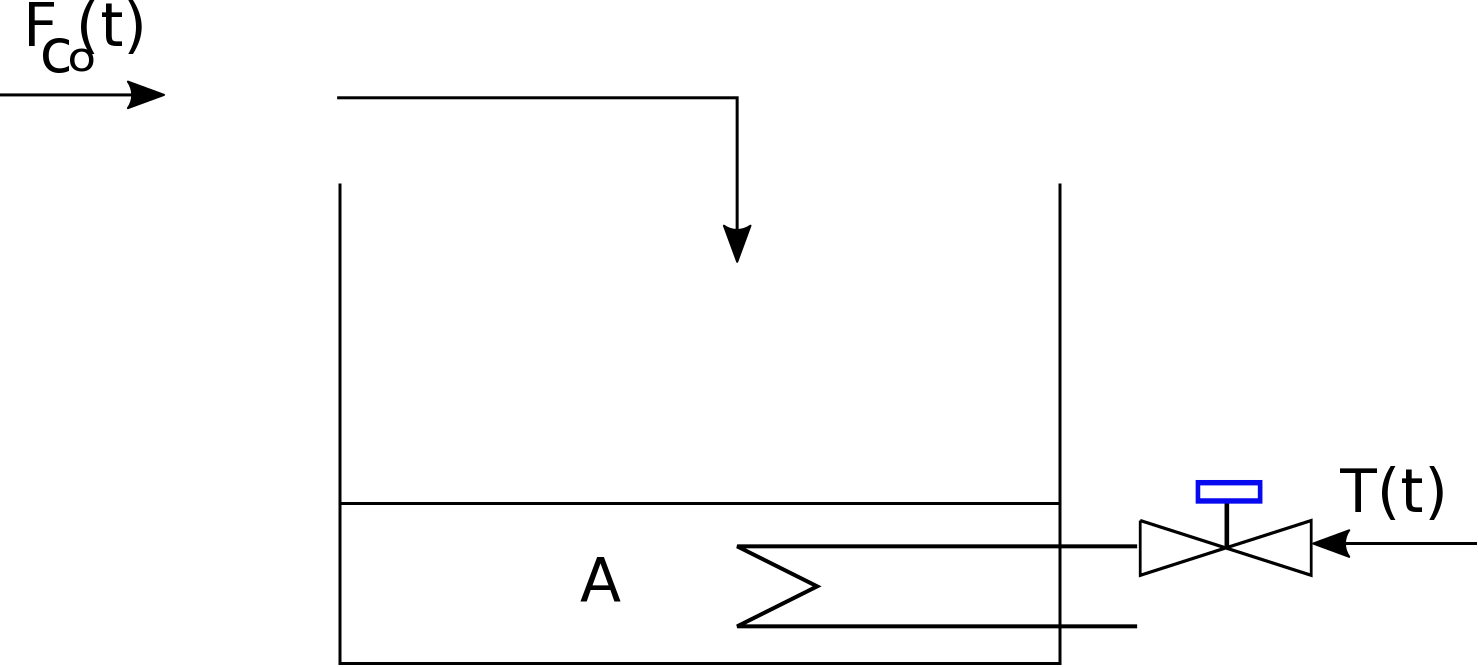

In [2]:
img = load("fig_sbatch.png")

The following set of consecutive and reversible chemical reactions take place in a non-isothermal
semibatch reactor:

\begin{eqnarray*}
A &\stackrel{K_1}{\longrightarrow}&  B \\
   B+C &\overset{K_2}{\underset{K_2^{'}}\rightleftarrows}& D \overset{K_3}{\underset{K_3^{'}}\rightleftarrows} E 
\end{eqnarray*}
As shown in the next figure, pure reactant $A$ is initially loaded into the reactor; trough thermal cracking  reactant $A$ 
decomposes into  product $B$. Moreover, reactant $C$ is added to form product $D$ (which is  the target product). However, because of the reaction mechanism, the lateral and undesired product $E$ is also formed.

You are asked to compute the optimal time-variant policies of both fed reactant $C$, denoted
as $F_c(t)$, and heating profiles, denoted as $T(t)$, such that at the end of the reaction period the amount of 
moles of component $D$ is maximized, while minimizing the amount of the remaining compounds ($A,B,C$ and $E$) and the reaction time. To meet this aim, deploy the following three objective functions:
\begin{eqnarray*}
\Omega_1 &=& \int  (N_D^2 - N_A^2 - N_B^2 - N_C^2 - N_E^2) dt  \\
\Omega_2 &=& \int \left( \frac{N_D^2}{N_A^2 + N_B^2 + N_C^2 + N_E^2} \right) dt \\
\Omega_3 &=& \int \left(  \frac{N_D}{N_A + N_B + N_C + N_E} \right)^2 dt 
 \end{eqnarray*}

*  For each one of the above objective functions report your results as time-variant  plots of: (a) number of moles of all
involved components, (b) reactor volume, (c) reactor temperature, (d) feeding policy of reactant C
and reaction selectivity ($S$) defined as:
$$ S = \frac{N_D}{N_A + N_B + N_C + N_E} $$

* Discuss the results  you observed. Which optimal control policy seems to be better? Why?


 It should be stressed that the reactor can be operated at maximum temperature of 1273 K, and that the maximum flowrate of reactant $C$ is 0.3 mol/min. Moreover, the maximum reactor volume is 1000 L. In the following table values of the kinetic parameters and initial conditions are provided.


The dynamic mathematical model of the reaction system reads,
\begin{eqnarray*}
\frac{dN_A}{dt} &=& r_A V\\
\frac{dN_B}{dt} &=& r_B V\\
\frac{dN_C}{dt} &=& F_{co} + r_C V\\
\frac{dN_D}{dt} &=& r_D V\\
\frac{dN_E}{dt} &=& r_E V\\
\frac{dV}{dt}      &=& \frac{F_{co}}{C_{co}}
\end{eqnarray*}
where $N_i, \, i=A,B,C,D,E$ stands for number of moles, $V$ is reactor volume and $C_{co}$ is the concentration  of
reactant $C$ in the feed stream. In addition, reaction rates are given ad follows: 
\begin{eqnarray*}
r_A &=& -K_1 C_A\\
r_B &=& K_1 C_A  - K_2 C_B C_C + K_{2}^{'} C_D \\
r_C &=& -K_2 C_B C_C + K_{2}^{'} C_D \\
r_D &=& K_2 C_B C_C - K_{2}^{'} C_D - K_3 C_D + K_{3}^{'} C_E\\
r_E &=& K_3 C_D - K_{3}^{'} C_E
\end{eqnarray*}
where $C_i, \, i=A,B,C,D,E$ stands for molar concentration. Moreover, all kinetics constants are temperature-depend trough Arrheniuns equation:
\begin{eqnarray*}
 K_i &=& A_i e^{-E_i/RT},\quad i=1,2,3  \\
 K_i^{'} &=& A_i^{'} e^{-E^{'}_i/RT},\quad i=2,3
 \end{eqnarray*}
  


| Parameters  |   Value   |   Units   | 
|:-----------:|:---------:|:---------:|
| $A_1$       | 7         | 1/min     | 
| $E_1$       | 2000      |cal/mol    | 
| $A_2$       | 850       | 1/min     |
| $E_2$       | 500       | cal/mol   |
| $A_2^{'}$   | 10        | L/(mol-min)     |
| $E_2^{'}$   | 5         | cal/mol   |
| $A_3$       | 900       | 1/min     |
| $E_3$       | 1600      | cal/mol   | 
| $A_3^{'}$   | 270       | 1/min     |
| $E_3^{'}$   | 480       | cal/mol   | 
| $R$         | 1.987     | cal/(mol-K)|
| $C_{co}$    | 0.05      | mol/L     |


#### Initial conditions

| Parameters  |   Value   |   Units   | 
|:-----------:|:---------:|:---------:|
|$N_A$        | 50        | Mol       |
|$N_B$        | 0         | Mol       |
|$N_C$        | 0         | Mol       |
|$N_D$        | 0         | Mol       |
|$N_E$        | 0         | Mol       |
|$V$          | 125       | L         | 
|$T$          | 303       | K         |
|$F_{co}$     | 0         | Mol/min   |

In [3]:
dynoptim_sbatchni = Model(solver=IpoptSolver());

In [4]:
np       = 1:100        # number of discretization points
a1       = 7            # 1/min
e1       = 2000         # cal/mol
a1p      = 0          # 1/min
e1p      = 0          # cal/mol
a2       = 850          # L/(mol-min)
e2       = 500          # cal/mol3
a2p      =  10          # 1/min
e2p      = 5           # cal/mol
a3       = 900          # 1/min
e3       = 1600         # cal/mol
a3p      = 270          # 1/min
e3p      = 480          # cal/mon

rgas     = 1.987        # cal/(mol-K)
rhoa     = 0.8          # Density of compound A, mol/L
cco      = 0.05         # feed concentration of compound C [mol/L] 

t0       = 0            # initial time [min]
tf       = 5*60        # end time
na_init  = 50          # Number of initial moles of compound A
nb_init  = 0            # Number of initial moles of compound B
nc_init  = 0            # Number of initial moles of compound C
nd_init  = 0            # Number of initial moles of compound D
ne_init  = 0            # Number of initial moles of compound E
v_init   = na_init/rhoa # Initial filling volume, L
t_init   = 30+273.16    # Initial reactor temperature, K
fco_init = 0            # Initial flowrate of reactant C, mol/L
t_max    = 1000+273.16  # Maximum reactor temperature, K
fco_max  = 0.3          # Maximum flowrate of reactant C, mol/min
v_max    = 1000;        # Maximum reactor volume

In [5]:
time  = Array{Float64}(undef, length(np))
w     = Array{Float64}(undef, length(np))
dt    = (tf-t0)/(length(np)-1)
for i = 1:length(np)
   time[i] = t0+(i-1)*dt
end
w[1] = 1
w[length(np)] = 1;
for i = 2:length(np)-1
    w[i] = 2
    if mod(i,2) == 0
       w[i] = 3
    end
end

In [6]:
@variable(dynoptim_sbatchni, 0       <= na[np]  <= na_init,    start = 0.5*na_init);
@variable(dynoptim_sbatchni,            nb[np]  >= 0      ,    start = 0.5*na_init);
@variable(dynoptim_sbatchni,            nc[np]  >= 0      ,    start = 0.5*na_init);
@variable(dynoptim_sbatchni,            nd[np]  >= 0      ,    start = 0.5*na_init);
@variable(dynoptim_sbatchni,            ne[np]  >= 0      ,    start = 0.5*na_init);
@variable(dynoptim_sbatchni, v_init <=  v[np]   <= v_max ,    start = v_init     );
@variable(dynoptim_sbatchni, t_init  <= t[np]   <= t_max  ,    start = t_init     );
@variable(dynoptim_sbatchni, 0       <= fco[np] <= fco_max,    start = fco_init   );

In [7]:
@constraint(dynoptim_sbatchni, icond_na,  na[1]  == na_init )
@constraint(dynoptim_sbatchni, icond_nb,  nb[1]  == nb_init )
@constraint(dynoptim_sbatchni, icond_nc,  nc[1]  == nc_init )
@constraint(dynoptim_sbatchni, icond_nd,  nd[1]  == nd_init )
@constraint(dynoptim_sbatchni, icond_ne,  ne[1]  == ne_init )
@constraint(dynoptim_sbatchni, icond_v,   v[1]   == v_init  )
@constraint(dynoptim_sbatchni, icond_t,   t[1]   == t_init  )
@constraint(dynoptim_sbatchni, icond_fco, fco[1] == fco_init);

In [8]:
@NLconstraint(dynoptim_sbatchni, dynmodel_na[i in 2:length(np)], 
  na[i] == na[i-1] + dt*( (-a1*exp(-e1/(rgas*t[i]))*(na[i]/v[i]) 
            + a1p*exp(-e1p/(rgas*t[i]))*(nb[i]/v[i]))*v[i]  )) ;

In [9]:
@NLconstraint(dynoptim_sbatchni, dynmodel_nb[i in 2:length(np)], 
  nb[i] == nb[i-1] + dt*( (a1 *exp(-e1/(rgas*t[i]))*(na[i]/v[i]) - a1p*exp(-e1p/(rgas*t[i]))*(nb[i]/v[i]) 
            - a2*exp(-e2/(rgas*t[i]))*(nb[i]/v[i])*(nc[i]/v[i]) + a2p*exp(-e2p/(rgas*t[i]))*(nd[i]/v[i]))*v[i] ) );

In [10]:
@NLconstraint(dynoptim_sbatchni, dynmodel_nc[i in 2:length(np)], 
  nc[i] == nc[i-1] + dt*( fco[i] + (-a2*exp(-e2/(rgas*t[i]))*(nb[i]/v[i])*(nc[i]/v[i]) 
            + a2p*exp(-e2p/(rgas*t[i]))*(nd[i]/v[i]))*v[i] ) );

In [11]:
@NLconstraint(dynoptim_sbatchni, dynmodel_nd[i in 2:length(np)], 
  nd[i] == nd[i-1] + dt*( (a2*exp(-e2/(rgas*t[i]))*(nb[i]/v[i])*(nc[i]/v[i]) - a2p*exp(-e2p/(rgas*t[i]))*(nd[i]/v[i]) 
            - a3 *exp(-e3/(rgas*t[i]))*(nd[i]/v[i]) + a3p*exp(-e3p/(rgas*t[i]))*(ne[i]/v[i]))*v[i] ) ) ;

In [12]:
@NLconstraint(dynoptim_sbatchni, dynmodel_ne[i in 2:length(np)], 
  ne[i] == ne[i-1] + dt*( (a3*exp(-e3/(rgas*t[i]))*(nd[i]/v[i]) - a3p*exp(-e3p/(rgas*t[i]))*(ne[i]/v[i]))*v[i] ));

In [13]:
@NLconstraint(dynoptim_sbatchni, dynmodel_v[i in 2:length(np)], 
  v[i] == v[i-1] + dt*( fco[i]/cco ) );

In [14]:
@NLobjective(dynoptim_sbatchni, Max, (dt/3)*sum(w[i]*( nd[i]^2 - ne[i]^2 - nc[i]^2 
            - na[i]^2 - nb[i]^2  ) for i in np ));

In [15]:
status_dynoptim_sbatchni = solve(dynoptim_sbatchni);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3374
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8123

Total number of variables............................:      800
                     variables with only lower bounds:      400
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equ

In [16]:
println("Objective function value = ", getobjectivevalue(dynoptim_sbatchni))

Objective function value = -207573.60741447427


In [17]:
timep    = Array{Float64}(undef, length(np))                
nap      = Array{Float64}(undef, length(np))                
nbp      = Array{Float64}(undef, length(np))                
ncp      = Array{Float64}(undef, length(np))                
ndp      = Array{Float64}(undef, length(np))                
nep      = Array{Float64}(undef, length(np))                
vp       = Array{Float64}(undef, length(np))                
tp       = Array{Float64}(undef, length(np))     
fcop     = Array{Float64}(undef, length(np))

for i = 1:length(np)
    timep[i] = time[i]/60
    nap[i]   = getvalue(na[i])   
    nbp[i]   = getvalue(nb[i])   
    ncp[i]   = getvalue(nc[i])   
    ndp[i]   = getvalue(nd[i])   
    nep[i]   = getvalue(ne[i])   
    vp[i]    = getvalue(v[i])   
    tp[i]    = getvalue(t[i])-273.16   
    fcop[i]  = getvalue(fco[i])   
end    

In [18]:
@NLobjective(dynoptim_sbatchni, Max, (dt/3)*sum(w[i]*( nd[i]^2/(ne[i]^2+nc[i]^2 
           + na[i]^2 + nb[i]^2)  ) for i in np ));

In [19]:
status_dynoptim_sbatchni = solve(dynoptim_sbatchni);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3374
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9123

Total number of variables............................:      800
                     variables with only lower bounds:      400
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      602
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [20]:
timep2    = Array{Float64}(undef, length(np))                
nap2      = Array{Float64}(undef, length(np))                
nbp2      = Array{Float64}(undef, length(np))                
ncp2      = Array{Float64}(undef, length(np))                
ndp2      = Array{Float64}(undef, length(np))                
nep2      = Array{Float64}(undef, length(np))                
vp2       = Array{Float64}(undef, length(np))                
tp2       = Array{Float64}(undef, length(np))     
fcop2     = Array{Float64}(undef, length(np))

for i = 1:length(np)
    timep2[i] = time[i]/60
    nap2[i]   = getvalue(na[i])   
    nbp2[i]   = getvalue(nb[i])   
    ncp2[i]   = getvalue(nc[i])   
    ndp2[i]   = getvalue(nd[i])   
    nep2[i]   = getvalue(ne[i])   
    vp2[i]    = getvalue(v[i])   
    tp2[i]    = getvalue(t[i])-273.16   
    fcop2[i]  = getvalue(fco[i])   
end    

In [21]:
@NLobjective(dynoptim_sbatchni, Max, (dt/3)*sum(w[i]*( nd[i]/(ne[i]+nc[i]
            + na[i] + nb[i])^2  ) for i in np ));

In [22]:
status_dynoptim_sbatchni = solve(dynoptim_sbatchni);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3374
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9123

Total number of variables............................:      800
                     variables with only lower bounds:      400
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      602
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [23]:
timep3    = Array{Float64}(undef, length(np))                
nap3      = Array{Float64}(undef, length(np))                
nbp3      = Array{Float64}(undef, length(np))                
ncp3      = Array{Float64}(undef, length(np))                
ndp3      = Array{Float64}(undef, length(np))                
nep3      = Array{Float64}(undef, length(np))                
vp3       = Array{Float64}(undef, length(np))                
tp3       = Array{Float64}(undef, length(np))     
fcop3     = Array{Float64}(undef, length(np))

for i = 1:length(np)
    timep3[i] = time[i]/60
    nap3[i]   = getvalue(na[i])   
    nbp3[i]   = getvalue(nb[i])   
    ncp3[i]   = getvalue(nc[i])   
    ndp3[i]   = getvalue(nd[i])   
    nep3[i]   = getvalue(ne[i])   
    vp3[i]    = getvalue(v[i])   
    tp3[i]    = getvalue(t[i])-273.16   
    fcop3[i]  = getvalue(fco[i])   
end    

In [24]:
s1     = Array{Float64}(undef, length(np))
s2     = Array{Float64}(undef, length(np))
s3     = Array{Float64}(undef, length(np))

for i = 1:length(np)
    s1[i] = ndp[i]/(nap[i]+nbp[i]+ncp[i]+nep[i])
    s2[i] = ndp2[i]/(nap2[i]+nbp3[i]+ncp2[i]+nep2[i])
    s3[i] = ndp3[i]/(nap3[i]+nbp3[i]+ncp3[i]+nep3[i])
end    

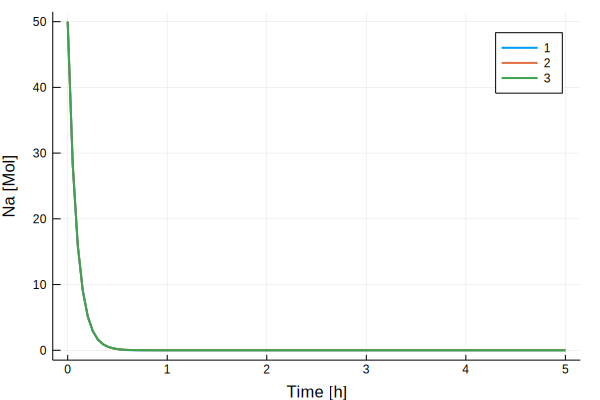

In [25]:
plot(timep,[nap,nap2,nap3],lw=2,xlabel="Time [h]",ylabel="Na [Mol]",label=["1" "2" "3"])

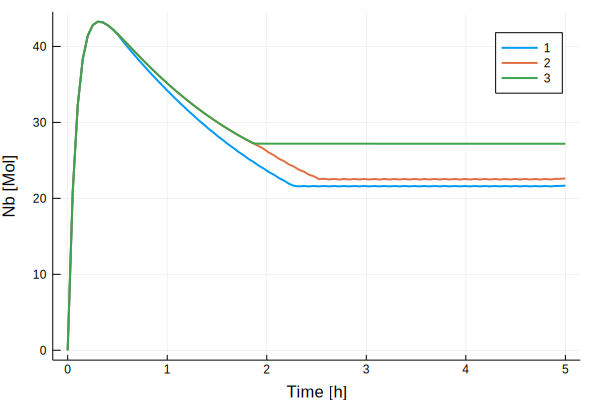

In [26]:
plot(timep,[nbp,nbp2,nbp3],lw=2,xlabel="Time [h]",ylabel="Nb [Mol]",label=["1" "2" "3"])

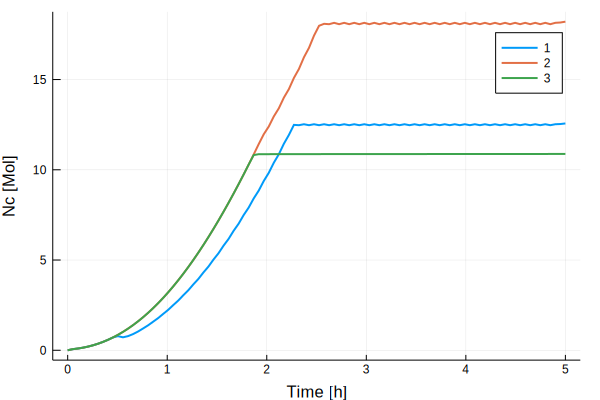

In [27]:
plot(timep,[ncp,ncp2,ncp3],lw=2,xlabel="Time [h]",ylabel="Nc [Mol]",label=["1" "2" "3"])

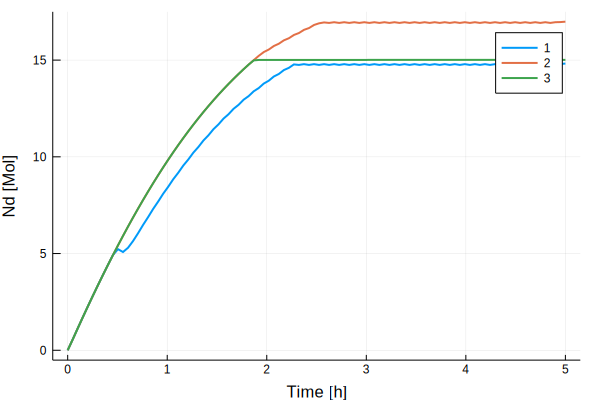

In [28]:
plot(timep,[ndp,ndp2,ndp3],lw=2,xlabel="Time [h]",ylabel="Nd [Mol]",label=["1" "2" "3"])

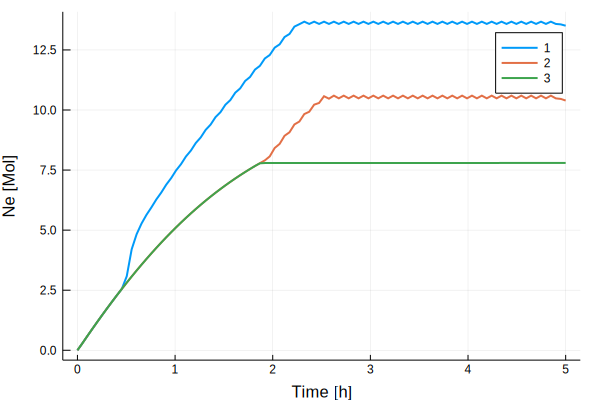

In [29]:
plot(timep,[nep,nep2,nep3],lw=2,xlabel="Time [h]",ylabel="Ne [Mol]",label=["1" "2" "3"])

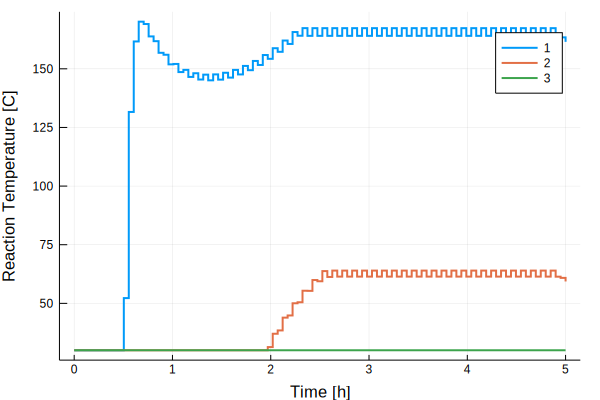

In [30]:
plot(timep,[tp,tp2,tp3],lw=2,linetype=:steppost,xlabel="Time [h]", ylabel="Reaction Temperature [C]",label=["1" "2" "3"])

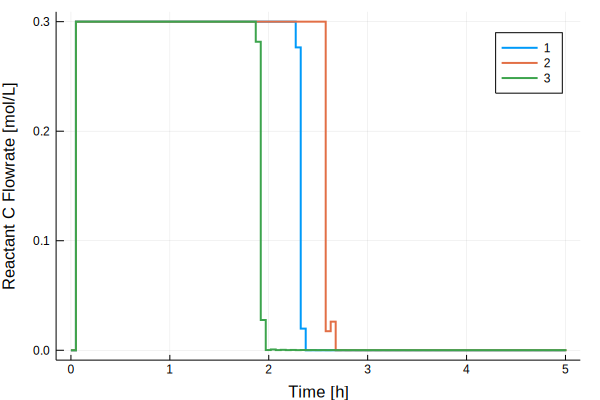

In [31]:
plot(timep,[fcop,fcop2,fcop3],lw=2,linetype=:steppost,xlabel="Time [h]", ylabel="Reactant C Flowrate [mol/L]",label=["1" "2" "3"])

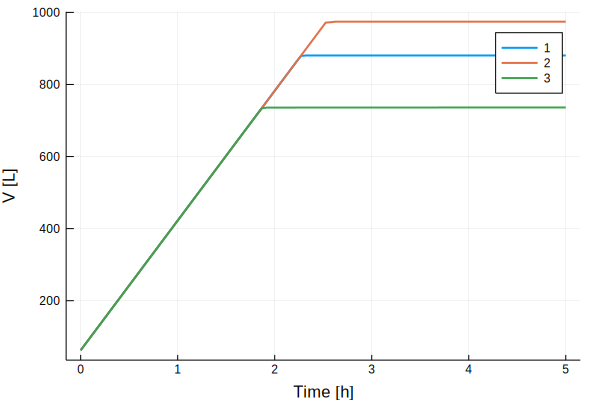

In [32]:
plot(timep,[vp,vp2,vp3],lw=2,xlabel="Time [h]",ylabel="V [L]",label=["1" "2" "3"])

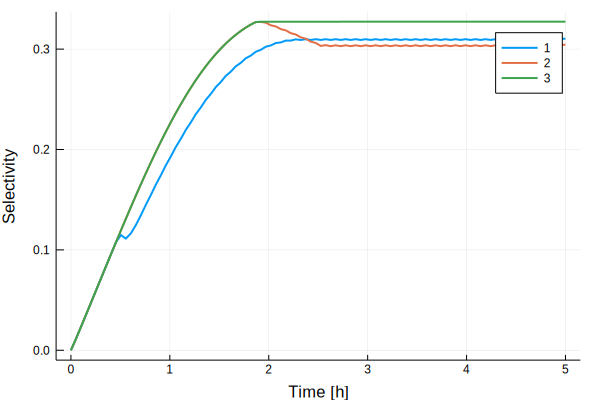

In [33]:
plot(timep,[s1,s2,s3],lw=2,xlabel="Time [h]",ylabel="Selectivity",label=["1" "2" "3"])